In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#/content/drive/MyDrive/kaggle_dataset/image_segmentation/BSR/BSDS500/data/images
from PIL import Image
import os
import cv2
import scipy.io as sio
from google.colab.patches import cv2_imshow
from numpy import asarray
import numpy as np
from scipy.io import loadmat
import scipy
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure, imshow, axis
import sys
from collections import Counter
from sklearn.cluster import SpectralClustering

# **Visualize**

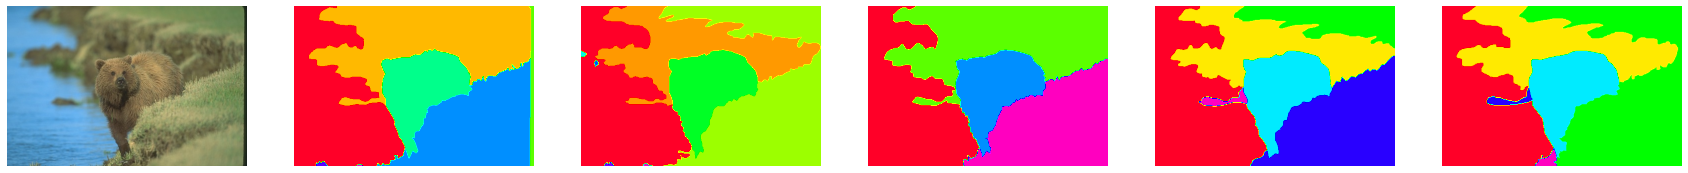

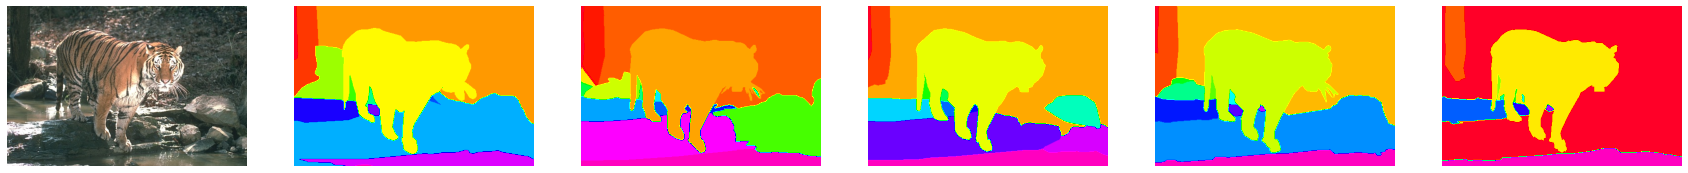

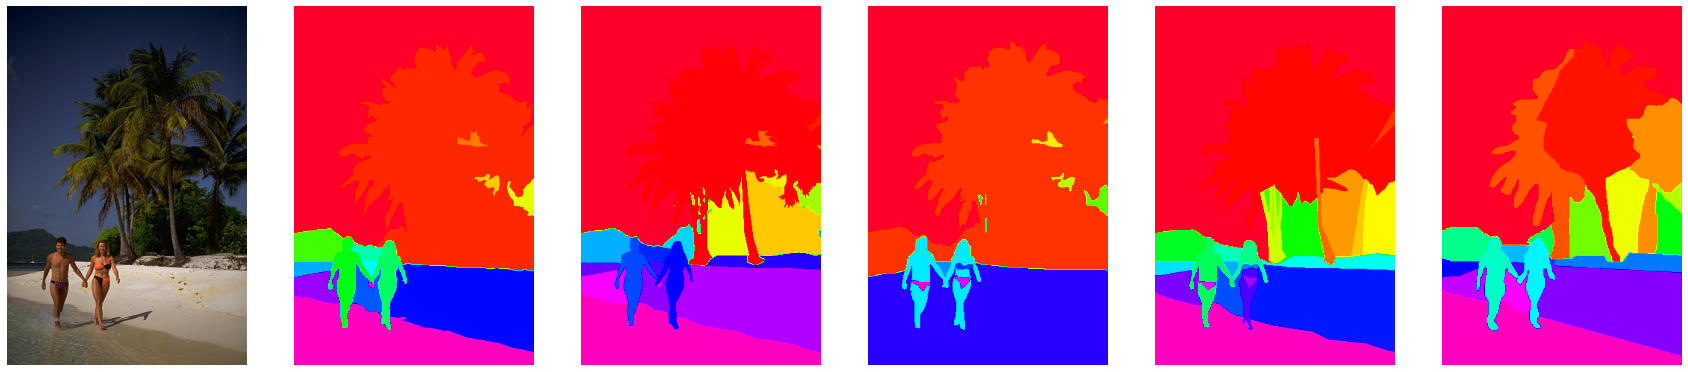

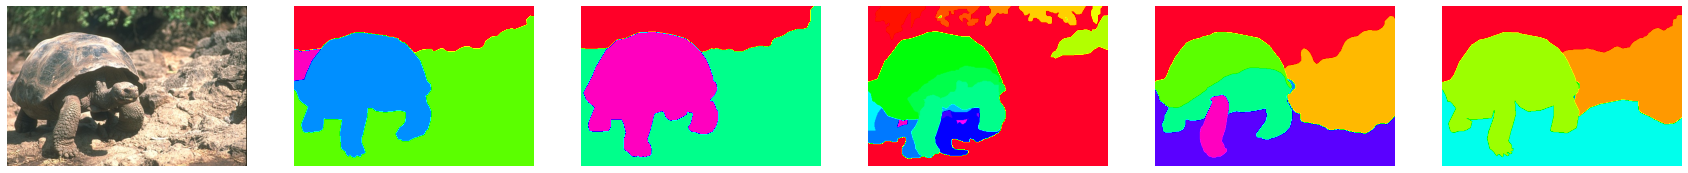

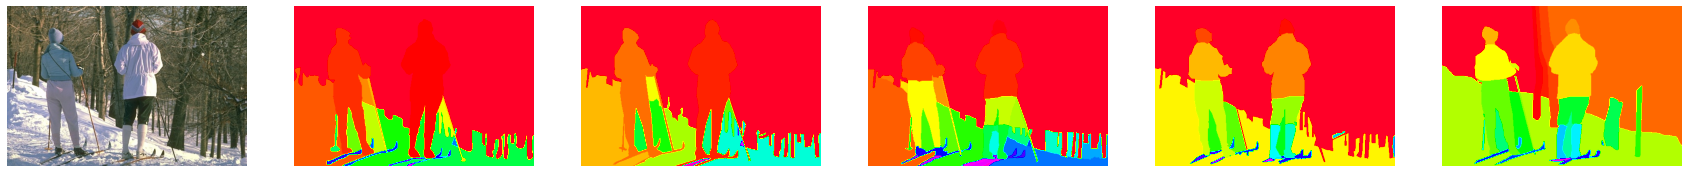

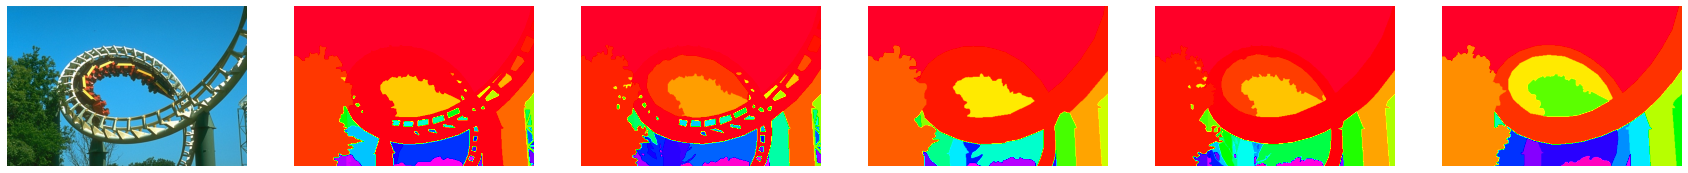

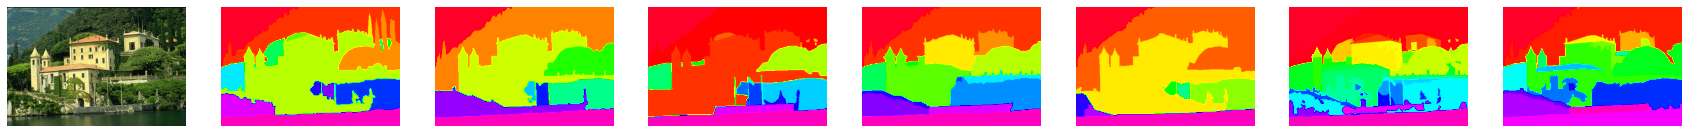

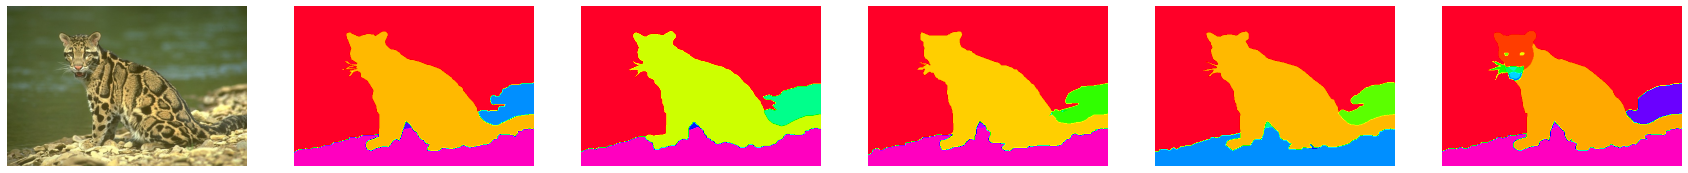

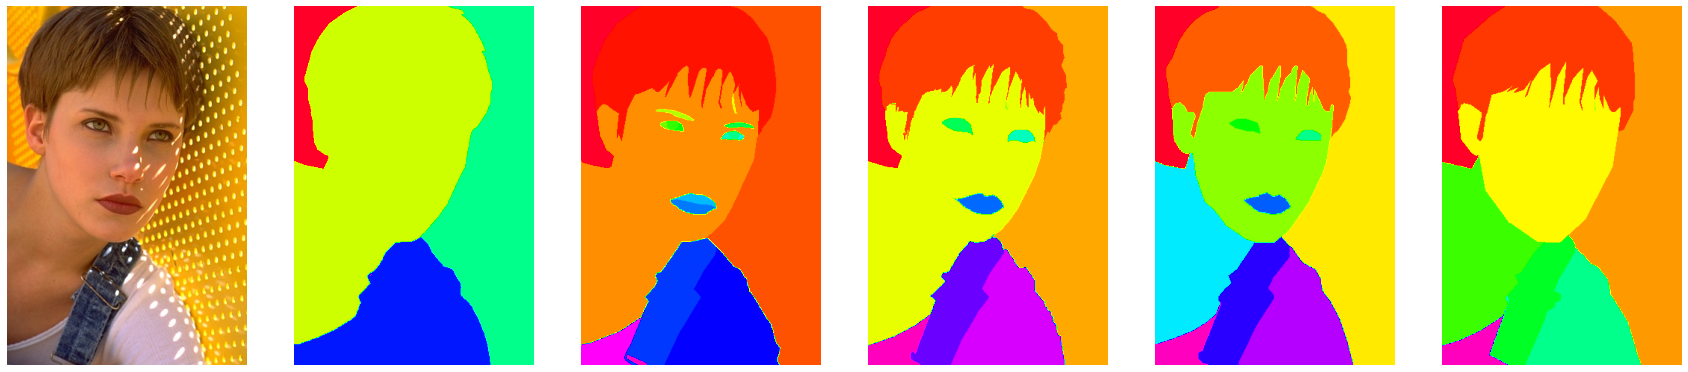

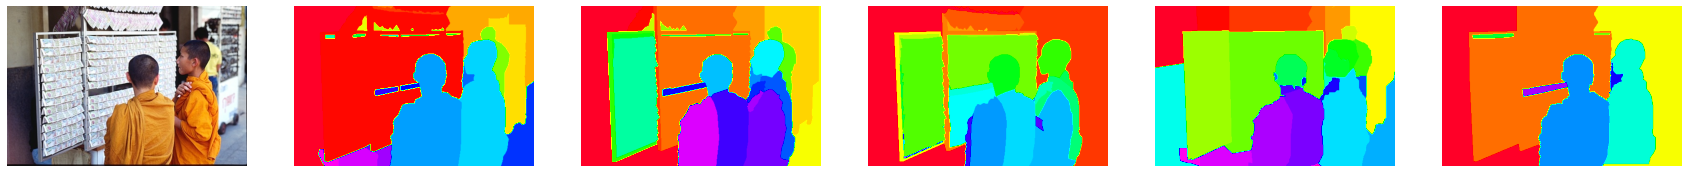

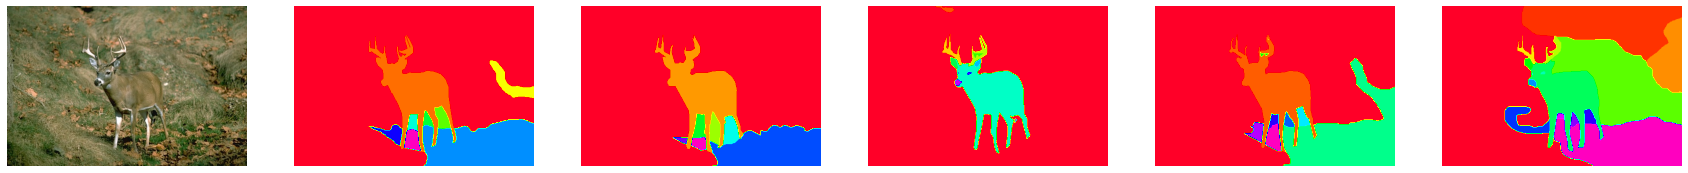

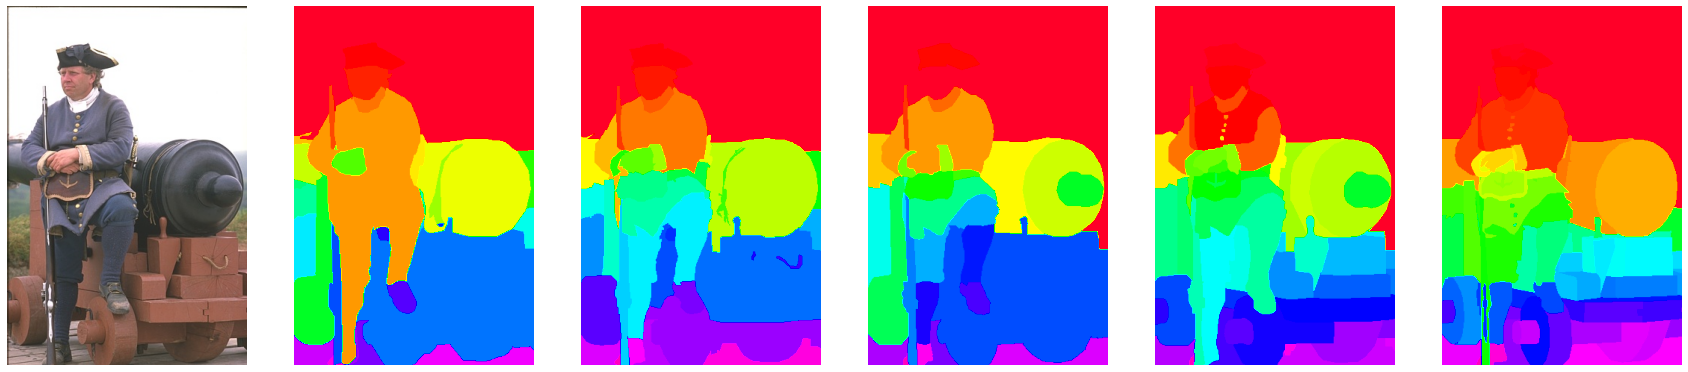

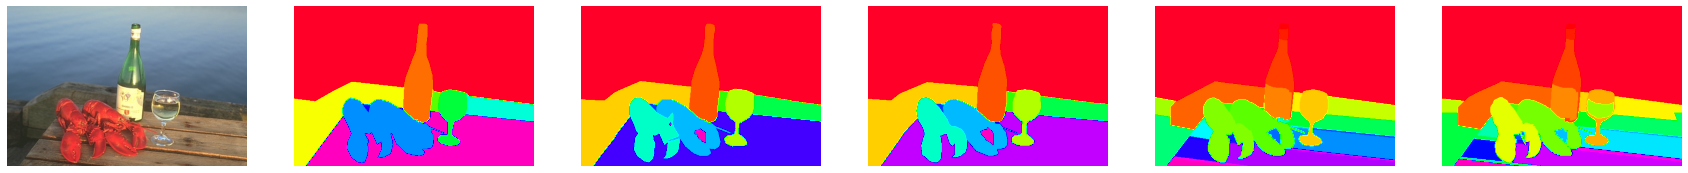

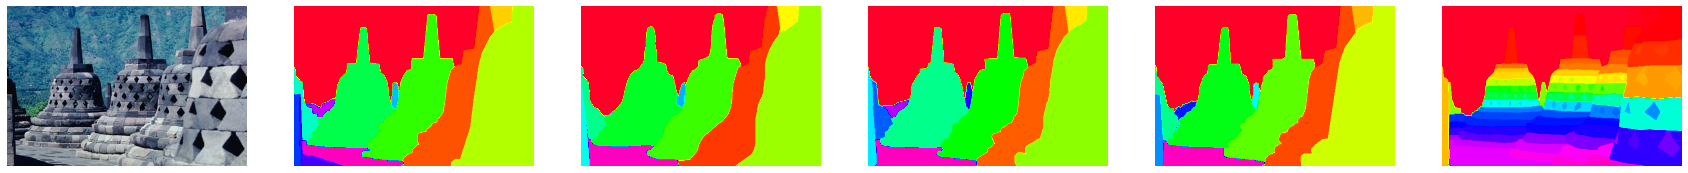

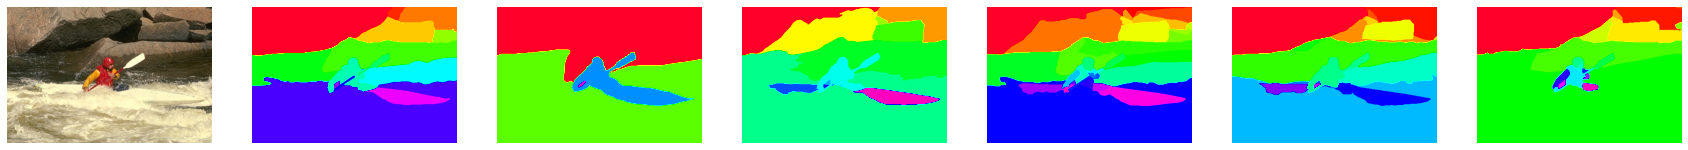

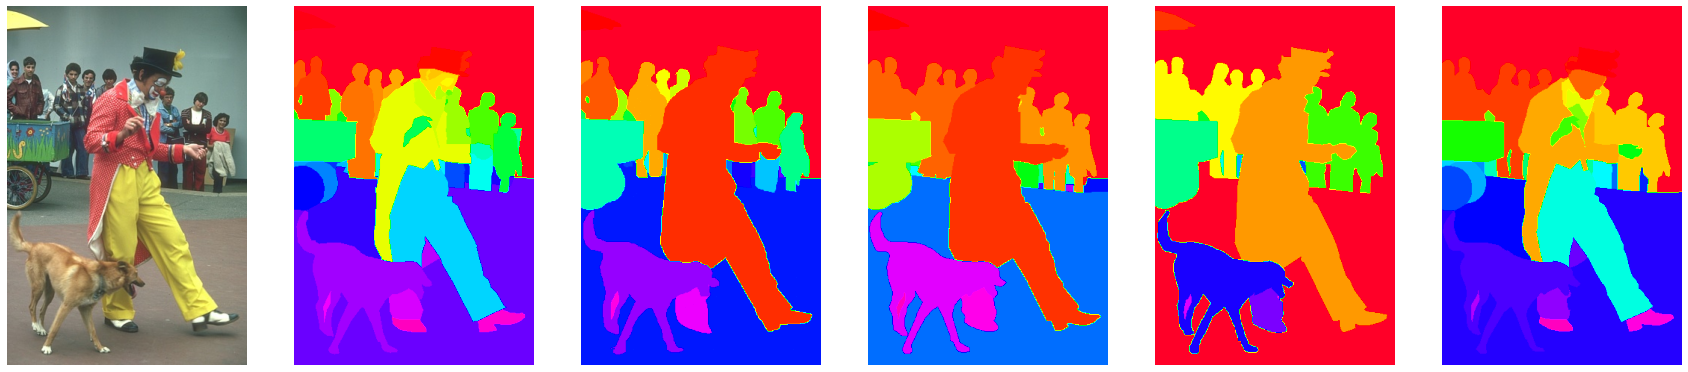

KeyboardInterrupt: ignored

In [ ]:
path1 = '/content/drive/MyDrive/kaggle_dataset/image_segmentation/BSR/BSDS500/data/images/test'
path2 ='/content/drive/MyDrive/kaggle_dataset/image_segmentation/BSR/BSDS500/data/groundTruth/test'
counter = 0
for imgname in os.listdir(path1):
  if imgname.endswith(".jpg"):
    img=cv2.imread(os.path.join(path1,imgname))
    ground_truth = sio.loadmat(os.path.join(path2,imgname.replace('.jpg','.mat')))
    row,col=ground_truth['groundTruth'].shape

    fig = figure(figsize=(30,30))

    a=fig.add_subplot(1,col+1,1)
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imshow(image)
    axis('off')
    for i in range(col):
      segmap_data = ground_truth['groundTruth'][0][i][0][0][0]
      segmap_uint8 = segmap_data.astype(np.uint8)
      a=fig.add_subplot(1,col+1,i+2)
      imshow(segmap_uint8 ,cmap='gist_rainbow')
      axis('off')
    plt.show()
    counter+=1
    if counter == 50 :
      break

# **F-measure**

In [ ]:
def f_measure(labels , groundtruth , centroids):
  F = 0
  for i in range(len(centroids)):
    count_of_cluster = 0
    cluster = []
    for j in range(len(labels)):
      if labels[j] == i :
        count_of_cluster+=1
        cluster.append(groundtruth[j])
    if len(cluster) != 0 :
      x = np.array(cluster)
      max_element = np.bincount(x).argmax()

      count_of_majority=0
      for c in cluster :
        if c == max_element:
          count_of_majority+=1

      total=0
      for g in groundtruth :
        if g == max_element:
          total+=1

      purity_of_cluster = count_of_majority / count_of_cluster
      recall_of_cluster = count_of_majority / total
      F_of_cluster = (2*purity_of_cluster*recall_of_cluster)/(purity_of_cluster+recall_of_cluster)
      F+=F_of_cluster

  F = F/len(centroids)
  return F

# **Conditional Entropy**

In [ ]:
def conditional_entropy(labels , groundtruth , centroids):
  H=0
  for i in range(len(centroids)):
    H_of_cluster = 0
    count_of_cluster = 0
    cluster = []
    for j in range(len(labels)):
      if labels[j] == i :
        count_of_cluster+=1
        cluster.append(groundtruth[j])
    
    c = Counter(cluster)
    array = c.most_common()
    for a in array:
      value, count = a
      H_of_cluster+=(count/count_of_cluster) * np.log2(count/count_of_cluster)

    H_of_cluster = H_of_cluster * -1
    H+=(count_of_cluster/len(labels))*H_of_cluster
  
  return H


# **K-Means**

In [ ]:
def kmean_clustering(pixels,K,e , iterations = 0):
  t=0
  row_pixels , col = pixels.shape
  labels=np.empty((row_pixels,1),dtype=int)
  #initialize centroids
  unique = np.unique(pixels , axis=0)
  centroids =np.array(unique[0:K, :],dtype=float)
  while 1:
    t+=1
    for pixel_index in range(row_pixels):
      min_distance = sys.maxsize
      index = -1
      for i in range(len(centroids)):
        centeroid = centroids[i]
        distance = np.linalg.norm(centeroid - pixels[pixel_index])
        if distance < min_distance :
          min_distance = distance
          index = i

      labels[pixel_index] = index
    old_centroids = np.array(centroids).copy()
    for j in range(len(centroids)):
      count = 0 
      sum=np.zeros((1,col))
      for p in range(row_pixels):
        if labels[p]==j:
          sum =sum+pixels[p]
          count+=1
      
      if count != 0:
        centroids[j] = sum /count
    
    stop = 0
    for k in range(len(centroids)):
      stop = stop + np.square(np.linalg.norm(old_centroids[k]-centroids[k]))
    
    if stop <= e :
      break
    
    if iterations !=0:
      if t == iterations :
        break

  return labels , centroids    

In [ ]:
path1 = '/content/drive/MyDrive/kaggle_dataset/image_segmentation/BSR/BSDS500/data/images/test'
path2 ='/content/drive/MyDrive/kaggle_dataset/image_segmentation/BSR/BSDS500/data/groundTruth/test'
K = [3,5,7,9,11]
counter = 0
Average_of_data_set_F = [0,0,0,0,0]
Average_of_data_set_H = [0,0,0,0,0]
for imgname in os.listdir(path1):
  if imgname.endswith(".jpg"):
    img=cv2.imread(os.path.join(path1,imgname))
    ground_truth = sio.loadmat(os.path.join(path2,imgname.replace('.jpg','.mat')))
    row,col=ground_truth['groundTruth'].shape
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # reshape the image to a 2D array of pixels and 3 color values (RGB)
    pixel_values = image.reshape((-1, 3))
    fig = figure(figsize=(30,30))

    #loop on every K
    for k in range(len(K)):
      print("K = ", str(K[k]))
      labels , centroids = kmean_clustering(pixel_values, K[k] ,0 ,20)
      labels_flatten = labels.flatten()

      #with every ground truth get F - measure and Conditional entropy
      F_measure=[]
      Conditional_Entropy=[]
      for i in range(col):
        segmap_data = ground_truth['groundTruth'][0][i][0][0][0]
        segmap_uint8 = segmap_data.astype(np.uint8)
        groundtruth_flatten = segmap_uint8.flatten()
        #F measure
        F = f_measure(labels_flatten , groundtruth_flatten , centroids)
        F_measure.append(F)
        #conditional entropy
        H = conditional_entropy(labels_flatten , groundtruth_flatten ,centroids)
        Conditional_Entropy.append(H)

      F_string = ','.join(str(x) for x in F_measure)
      print("F measure : "+F_string)
      
      avg_f=sum(F_measure)/len(F_measure)
      print("Average of F-measure : "+str(avg_f))
      
      H_string = ','.join(str(x) for x in Conditional_Entropy)
      print("Conditional Entropy : "+H_string)
      
      avg_h=sum(Conditional_Entropy)/len(Conditional_Entropy)
      print("Average of Conditional Entropy : "+str(avg_h))

      Average_of_data_set_F[k] += avg_f
      Average_of_data_set_H[k] += avg_h

      
      segmentation_pixels = np.array(pixel_values).copy()
      a=fig.add_subplot(1,len(K),k+1)
      #construct the segmentation image
      for j in range(len(labels)):
        segmentation_pixels[j] = centroids[labels[j]]
      segmentation = segmentation_pixels.reshape(image.shape)
      imshow(segmentation)
      axis('off')

    plt.show()

    counter+=1
    if counter == 50 :
      break

Average_of_data_set_F[:] = [x / 50 for x in Average_of_data_set_F]
Average_of_data_set_H[:] = [x / 50 for x in Average_of_data_set_H]

Average_F_string = ','.join(str(x) for x in Average_of_data_set_F)
Average_H_string = ','.join(str(x) for x in Average_of_data_set_H)

print("Average F-measure of data set : "+Average_F_string)
print("Average Conditional Entropy of data set : "+Average_H_string)

# **Big Picture**

F measure (K means) : 0.28717205346944363,0.25580185078469253,0.2887011497845501,0.26285851617807776,0.2618622678417174
Average of F-measure (K means) : 0.27127916761169624
Conditional Entropy (K means) : 1.4695649997573064,1.844157523770908,1.4034758006645591,1.9569234885857898,1.8220832225854864
Average of Conditional Entropy (K means) : 1.6992410070728101


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


F measure (Normalized Cut) : 0.15467279041807327,0.12044675436393175,0.15559086458432356,0.12256613787954503,0.12151758620911465
Average of F-measure (Normalized Cut) : 0.13495882669099765
Conditional Entropy (Normalized Cut) : 1.4961041531843107,1.8735716292786289,1.4309124331002157,2.0033641586021096,1.8510755409949236
Average of Conditional Entropy (Normalized Cut) : 1.7310055830320377


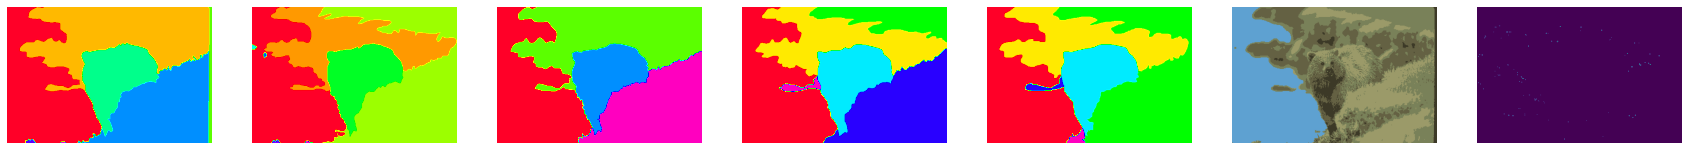

F measure (K means) : 0.25814351055484525,0.26397748234629576,0.23492525960022242,0.25447429011804645,0.1640721684685435
Average of F-measure (K means) : 0.23511854221759068
Conditional Entropy (K means) : 1.601747039956113,1.457491385593436,1.3237663509507462,1.3839166277519133,1.2380607671371415
Average of Conditional Entropy (K means) : 1.40099643427787


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


F measure (Normalized Cut) : 0.1362721216370557,0.1431222119649057,0.13562880895901427,0.14109376466682924,0.10948216870353385
Average of F-measure (Normalized Cut) : 0.13311981518626775
Conditional Entropy (Normalized Cut) : 1.608171025286591,1.4633712605367244,1.328533255271028,1.3894854358466084,1.2428023357843356
Average of Conditional Entropy (Normalized Cut) : 1.4064726625450574


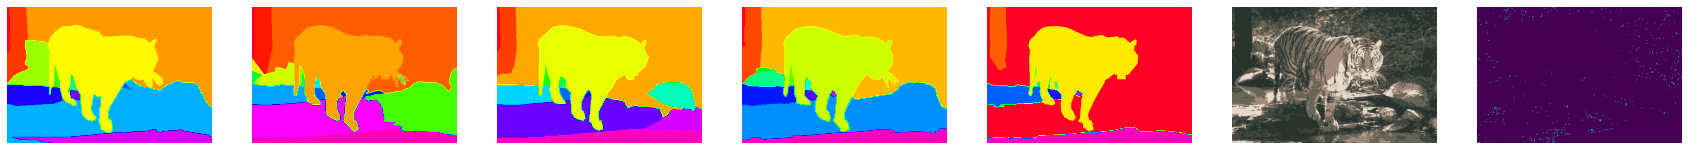

F measure (K means) : 0.3060779184895998,0.3338757274425323,0.2995824015393699,0.3383177720727234,0.30071583950224534
Average of F-measure (K means) : 0.31571393180929413
Conditional Entropy (K means) : 0.8847275724924053,0.9317118760800468,0.8866675297613827,0.9405326429930736,1.4863667975318824
Average of Conditional Entropy (K means) : 1.0260012837717583


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


KeyboardInterrupt: ignored

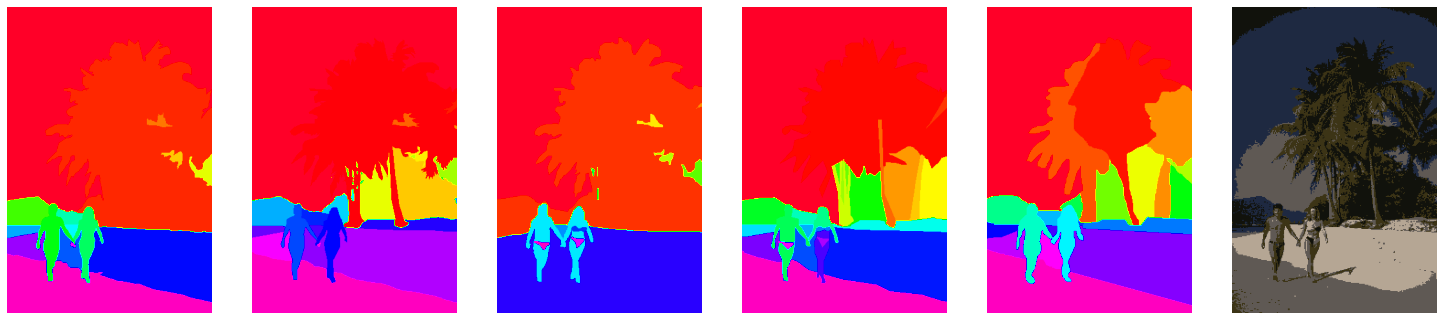

In [ ]:
path1 = '/content/drive/MyDrive/kaggle_dataset/image_segmentation/BSR/BSDS500/data/images/test'
path2 ='/content/drive/MyDrive/kaggle_dataset/image_segmentation/BSR/BSDS500/data/groundTruth/test'
counter = 0
for imgname in os.listdir(path1):
  if imgname.endswith(".jpg"):
    img=cv2.imread(os.path.join(path1,imgname))
    rows,cols,dim = img.shape
    img =  cv2.resize(img, (int(0.7*rows),int(0.7*cols)))
    ground_truth = sio.loadmat(os.path.join(path2,imgname.replace('.jpg','.mat')))
    row,col=ground_truth['groundTruth'].shape
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # reshape the image to a 2D array of pixels and 3 color values (RGB)
    pixel_values = image.reshape((-1, 3))

    fig = figure(figsize=(30,30))

    for i in range(col):
      segmap_data = ground_truth['groundTruth'][0][i][0][0][0]
      segmap_uint8 = segmap_data.astype(np.uint8)
      a=fig.add_subplot(1,col+2,i+1)
      imshow(segmap_uint8 ,cmap='gist_rainbow')
      axis('off')

    #K-means
    labels , centroids = kmean_clustering(pixel_values, 5 ,0 ,20)

    F_measure=[]
    Conditional_Entropy=[]
    labels_flatten=labels.flatten()
    for i in range(col):
      segmap_data = ground_truth['groundTruth'][0][i][0][0][0]
      segmap_uint8 = segmap_data.astype(np.uint8)
      groundtruth_flatten = segmap_uint8.flatten()
      F = f_measure(labels_flatten , groundtruth_flatten , [0,0,0,0,0])
      F_measure.append(F)
      H = conditional_entropy(labels_flatten , groundtruth_flatten , [0,0,0,0,0])
      Conditional_Entropy.append(H)

    F_string = ','.join(str(x) for x in F_measure)
    print("F measure (K means) : "+F_string)
      
    avg_f=sum(F_measure)/len(F_measure)
    print("Average of F-measure (K means) : "+str(avg_f))
      
    H_string = ','.join(str(x) for x in Conditional_Entropy)
    print("Conditional Entropy (K means) : "+H_string)
      
    avg_h=sum(Conditional_Entropy)/len(Conditional_Entropy)
    print("Average of Conditional Entropy (K means) : "+str(avg_h))
    

    segmentation_pixels = np.array(pixel_values).copy()
    a=fig.add_subplot(1,col+2,col+1)
    #construct the segmentation image
    for j in range(len(labels)):
      segmentation_pixels[j] = centroids[labels[j]]
    segmentation = segmentation_pixels.reshape(image.shape)
    imshow(segmentation)
    axis('off')

    #Nornalized cut
    sc = SpectralClustering(affinity='nearest_neighbors', n_clusters=5,n_jobs=-1,random_state=0).fit(pixel_values)
    
    labels2 = sc.labels_
    labels2_flatten=labels2.flatten()

    F_measure=[]
    Conditional_Entropy=[]
    for i in range(col):
      segmap_data = ground_truth['groundTruth'][0][i][0][0][0]
      segmap_uint8 = segmap_data.astype(np.uint8)
      groundtruth_flatten = segmap_uint8.flatten()
      F = f_measure(labels2_flatten , groundtruth_flatten , [0,0,0,0,0])
      F_measure.append(F)
      H = conditional_entropy(labels2_flatten , groundtruth_flatten , [0,0,0,0,0])
      Conditional_Entropy.append(H)

    F_string = ','.join(str(x) for x in F_measure)
    print("F measure (Normalized Cut) : "+F_string)
      
    avg_f=sum(F_measure)/len(F_measure)
    print("Average of F-measure (Normalized Cut) : "+str(avg_f))
      
    H_string = ','.join(str(x) for x in Conditional_Entropy)
    print("Conditional Entropy (Normalized Cut) : "+H_string)
      
    avg_h=sum(Conditional_Entropy)/len(Conditional_Entropy)
    print("Average of Conditional Entropy (Normalized Cut) : "+str(avg_h))

    a=fig.add_subplot(1,col+2,col+2)
    segmentation = labels2.reshape((image.shape[0],image.shape[1]))
    imshow(segmentation)
    axis('off')

    plt.show()
    counter+=1
    if counter == 5 :
      break